Importing modules

In [2]:
%matplotlib notebook
import numpy as np
import cv2
import glob

# This is a value for the termination criterion of the subpixel corner localizer
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

Creation of the 3D point coordinates and loading images

In [3]:
# Here you have 3D points for the checkerboard (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)
# Here you load the image files
images = glob.glob('left1.jpg')

print(images)


['left1.jpg']


Cell 1

In [4]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
for fname in images:
    #reading an image
    img = cv2.imread(fname)
    # transforming the image to gray scale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (7,6),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)
        
print(gray)

[[ 0  2  4 ...  0  0  0]
 [ 1  2  4 ...  4  3  6]
 [ 1  3  4 ...  6  5  3]
 ...
 [ 7 38 44 ... 56 47 11]
 [ 6 35 38 ... 43 40  8]
 [ 0 12 13 ... 12 14  0]]


Cell 2

In [5]:
retval, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)



In [6]:
print("rotation vector size",len(rvecs))

rotation vector size 1


In [7]:
for rvec in rvecs:
    R,jacobian=cv2.Rodrigues(rvec)
    print(jacobian)
    print("\n")

[[-0.26097886  0.28374583 -0.53739407 -0.14239609  0.01023     0.00667944
  -0.59078544 -0.07106488  0.26314201]
 [-0.01069833 -0.25458238 -0.03791587 -0.01756449  0.15016353 -0.63076033
  -0.02646957 -0.57736896 -0.1463582 ]
 [ 0.08538848  0.9045587   0.23534751 -0.96894414  0.0454136   0.14808597
  -0.00167038 -0.27805596 -0.07578573]]




In [8]:
Rm=[]
for rvec in rvecs:
    R,jacobian=cv2.Rodrigues(rvec)
    Rm.append(R)
    print(R)
    print("\n")
    
print(Rm)
print(len(Rm))

[[-0.90445156 -0.0254109   0.42581881]
 [-0.08042725 -0.97016312 -0.22872468]
 [ 0.4189258  -0.24111783  0.87542182]]


[array([[-0.90445156, -0.0254109 ,  0.42581881],
       [-0.08042725, -0.97016312, -0.22872468],
       [ 0.4189258 , -0.24111783,  0.87542182]])]
1


Camera matrix refinement

Cell 3

Cell 4

# Part B

# # 1

Load teapot point cloud coordinates

In [9]:
import pandas as pd
import matplotlib.animation

In [10]:
# Load from text file
tp= np.loadtxt("teapot.txt",usecols=range(3))
# Number of points in the cloud
n_points = np.shape(tp)
# Transpose and add a fourth coordinate with unitary value 
# (homogeneous coordinates)
tp = np.hstack((tp,np.ones((n_points[0],1),dtype=np.float))).T
# Save it in a data frame
df = pd.DataFrame({"x" : tp[0,:], "y" :tp[1,:], "z" : tp[2,:], 
                                                "w": tp[3,:]})

print(tp)

[[ 1.38137   1.4       1.35074  ...  0.350254  0.313617  0.228728]
 [ 0.        0.       -0.375926 ...  0.097771  0.087529  0.063803]
 [ 2.45469   2.4       2.4      ...  3.06667   2.98125   2.88333 ]
 [ 1.        1.        1.       ...  1.        1.        1.      ]]


In [11]:
# Scaling matrix
def scaling_matrix(s):
    # Scales are given in numpy array s
    # s=np.array([s_x,s_y,s_z])
    
    # Write the scaling matrix here
    S = np.identity(4)
    S[:3, :3] = np.diag(s)
    
    return S

# Translation matrix
def translation_matrix(t):
    # Translation vector is given in numpy array t
    # t=np.array([t_x,t_y,t_z])
    
    # Write the translation matrix here
    T = np.identity(4)
    T[:3, 3] = t
    
    return T

# Rotation matrix
def rotation_matrix(theta, v):
    # Axis for rotation (unit norm vector) is given 
    # is given in numpy array v
    # v=np.array([v_x,v_y,v_z])
    # Rotation angle is given in theta
    
    # Write the rotation matrix here
    st = np.sin(theta)
    ct = np.cos(theta)
    o_ct = 1-ct
    vx2= v[0]**2
    vy2= v[1]**2
    vz2= v[2]**2
    vxy = v[0]*v[1]
    vxz = v[0]*v[2]
    vyz= v[1]*v[2]
    # Rotation
    R = [[ct+vx2*o_ct, vxy*o_ct-v[2]*st, vxz*o_ct+v[1]*st],
         [vxy*o_ct+v[2]*st, ct+vy2*o_ct, vyz*o_ct-v[0]*st],
         [vxz*o_ct-v[1]*st, vyz*o_ct+v[0]*st, ct+vz2*o_ct]]
    R_v = np.identity(4)
    R_v[:3, :3] = R
    
    return R_v

mtx : intrinsic matrix (Mint)
R: rotation matrix
t: translation matrix

[R t] : extrinsic matrix (Mext)


Camera matrix= Mint Mext

In [12]:
Mext=[]
for i in range(len(Rm)):
    Rt_matrix = np.concatenate((Rm[i],tvecs[i]), axis=1)
    Mext.append(Rt_matrix)
    print(Rt_matrix)
    print("\n")

[[-0.90445156 -0.0254109   0.42581881  4.76671966]
 [-0.08042725 -0.97016312 -0.22872468 -1.27078405]
 [ 0.4189258  -0.24111783  0.87542182 22.62597546]]




In [13]:
import numpy

In [14]:
Ms=[]
for i in range(len(Rm)):
    Mi=numpy.matmul(mtx[i],Mext[i])
    Ms.append(Mi)
    print(Mi)
    print("\n")

[ -635.07555905   -93.66384666   620.60024245 10792.74778326]




In [15]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [16]:
def update_graph(num):
    # Load point cloud from data frame
    tp=np.vstack((df['x'],df['y'],df['z'],df['w']))
    angle = num*0.01
    # Create uniform scaling matrix 
    M = scaling_matrix([0.5,0.5,-0.5])
    #M = scaling_matrix([1.0,1.0,1.0])
    tp_r = np.dot(M,tp)
    graph._offsets3d = (tp_r[0,:], tp_r[1,:], tp_r[2,:])
    return graph



<IPython.core.display.Javascript object>


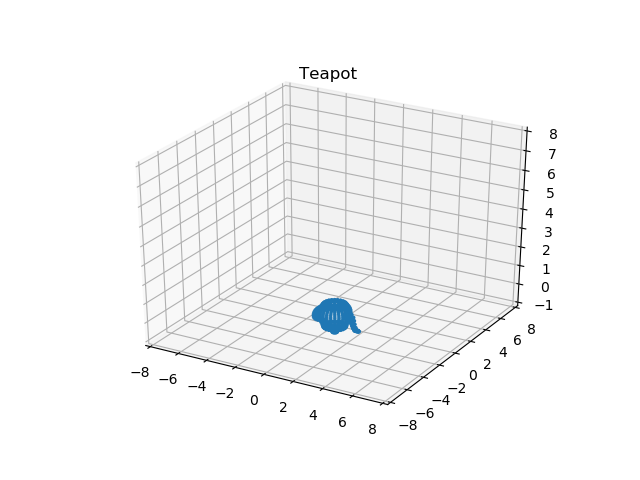

In [17]:
# 3D figure generation

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('Teapot')

# 3D scatter plot
graph = ax.scatter(tp[0,:], tp[1,:], tp[2,:],s=2)
# # Change axis limits if necessary
ax.set_xlim3d(-8, 8)
ax.set_ylim3d(-8, 8)
ax.set_zlim3d(-1, 8)

# Animation function
ani = matplotlib.animation.FuncAnimation(fig, update_graph,1000, 
                                            interval=1, blit=False)


plt.show()

In [18]:
tp1=update_graph(1000)

tp2=np.ndarray((4,1177))
#print(tp1._offsets3d)
#print("\n")
print(tp1._offsets3d[0])
#print("\n")
print(tp1._offsets3d[1])
#print("\n")
print(tp1._offsets3d[2])

print("\n")
print("tp")
print(tp)
print(type(tp))
print(tp.shape)
#print(tp2)
print("\n")
tp2[0]=(tp1._offsets3d[0])
tp2[1]=(tp1._offsets3d[1])
tp2[2]=(tp1._offsets3d[2])
print("hello")
print(tp2)

[0.690685  0.7       0.67537   ... 0.175127  0.1568085 0.114364 ]
[ 0.         0.        -0.187963  ...  0.0488855  0.0437645  0.0319015]
[-1.227345 -1.2      -1.2      ... -1.533335 -1.490625 -1.441665]


tp
[[ 1.38137   1.4       1.35074  ...  0.350254  0.313617  0.228728]
 [ 0.        0.       -0.375926 ...  0.097771  0.087529  0.063803]
 [ 2.45469   2.4       2.4      ...  3.06667   2.98125   2.88333 ]
 [ 1.        1.        1.       ...  1.        1.        1.      ]]
<class 'numpy.ndarray'>
(4, 1177)


hello
[[ 0.690685   0.7        0.67537   ...  0.175127   0.1568085  0.114364 ]
 [ 0.         0.        -0.187963  ...  0.0488855  0.0437645  0.0319015]
 [-1.227345  -1.2       -1.2       ... -1.533335  -1.490625  -1.441665 ]
 [ 1.         1.         1.        ...  1.         1.         1.       ]]


<IPython.core.display.Javascript object>


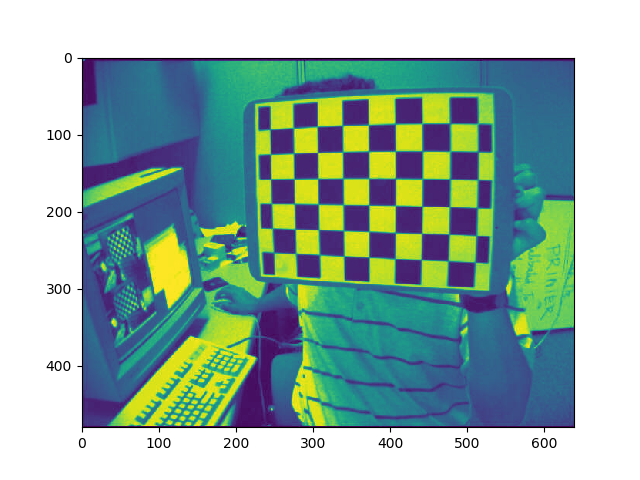

In [26]:
import matplotlib.image as mpimg
#from mpl_toolkits.mplot3d import Axes3D


u_sim=np.dot(Mi,tp2)
u_sim=u_sim/u_sim[2]
#df2 = pd.DataFrame({"x" :u_sim[0,:], "y" :u_sim[1,:], "w" : u_sim[2,:]})

fig=plt.figure()

img=mpimg.imread('left1.jpg')
plt.imshow(img)
plt.scatter(u_sim[0],u_sim[1],s=2)


plt.show()




method for rotation + translation

In [27]:
def rotation_matrix2d(theta):
    # Axis for rotation (unit norm vector) is given 
    # is given in numpy array v
    # v=np.array([v_x,v_y,v_z])
    # Rotation angle is given in theta
    
    # Write the rotation matrix here
    sin = np.sin(theta)
    cos = np.cos(theta)

    # Rotation
    R = [[cos, -sin],
         [sin,  cos]]
    R_v = np.identity(3)
    R_v[:2, :2] = R
    
    return R_v

def scaling_matrix2d(s):
    # Scales are given in numpy array s
    # s=np.array([s_x,s_y,s_z])
    
    # Write the scaling matrix here
    S = np.identity(3)
    S[:2, :2] = np.diag(s)
    
    return S

# Translation matrix
def translation_matrix2d(t):
    # Translation vector is given in numpy array t
    # t=np.array([t_x,t_y,t_z])
    
    # Write the translation matrix here
    T = np.identity(3)
    T[:2, 2] = t
    
    return T

In [36]:
def update_graph2(num):
    # Load point cloud from data frame
    tp=np.vstack((df2['x'],df2['y'],df2['w']))
    angle = num*0.01
 
    M = scaling_matrix2d([1.0,1.0])

    #M = scaling_matrix([1.0,1.0,-1.0])
    # Compose M with rotation matrix
    M = np.dot(rotation_matrix2d(angle),M)
    
    # Compose M with translation matrix
    M = np.dot(translation_matrix2d(np.array([2.5,0.0])),M)
    M = np.dot(rotation_matrix2d(angle),M)
    # Apply composed transformation to the point cloud
    tp_r = np.dot(M,tp)
    # Update scatter plot
    graph._offsets2d = (tp_r[0,:], tp_r[1,:])
    return graph


<IPython.core.display.Javascript object>


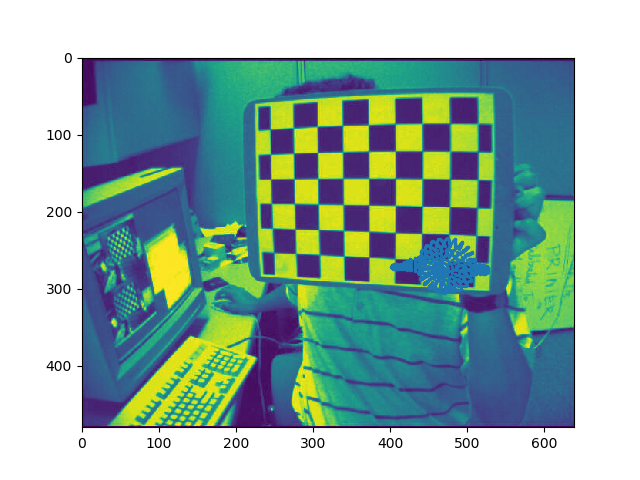

In [38]:

fig = plt.figure()
img=mpimg.imread('left1.jpg')
plt.imshow(img)
# 3D scatter plot
graph = plt.scatter(u_sim[0][0,:],u_sim[0][1,:],s=2)


# Animation function
ani = matplotlib.animation.FuncAnimation(fig, update_graph2,1000, 
                                            interval=10, blit=False)


plt.show()
    